In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Union, Any
import warnings
import random
from Base_models import FeedForwardPredictor, AutoEncoder, ElasticNetLoss
import math

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  # might slow down but ensures reproducibility
    torch.backends.cudnn.benchmark = False
    
set_seed()

def calculate_sharpe_ratio(returns: np.ndarray, rf_rate: float = 0.02) -> float:
    """Calculate annualized Sharpe ratio"""
    if len(returns) == 0 or np.std(returns) == 0:
        return 0.0
    excess_returns = returns - rf_rate/12  # Monthly risk-free rate
    return np.sqrt(12) * np.mean(excess_returns) / np.std(excess_returns)

def calculate_sortino_ratio(returns: np.ndarray, rf_rate: float = 0.02) -> float:
    """Annualised Sortino ratio (down-side risk only)."""
    if len(returns) == 0:
        return 0.0
    excess = returns - rf_rate / 12          # monthly risk-free
    downside = excess[excess < 0]
    if downside.size == 0:
        return np.inf
    return np.sqrt(12) * excess.mean() / downside.std()

def hit_rate(pred: np.ndarray, targ: np.ndarray) -> float:
    """Percentage of months the sign is predicted correctly."""
    return np.mean(np.sign(pred) == np.sign(targ))

def prepare_data_for_model(X: np.ndarray, y: np.ndarray, model_type: str, 
                          seq_length: int = 12) -> Tuple[torch.Tensor, torch.Tensor]:
    """Prepare data based on model type (feedforward vs LSTM)"""
    if model_type.lower() in ['lstm', 'transformer']:
        # For LSTM, create sequences
        X_seq, y_seq = [], []
        for i in range(seq_length, len(X)):
            X_seq.append(X[i-seq_length:i])
            y_seq.append(y[i])
        return torch.FloatTensor(np.array(X_seq)), torch.FloatTensor(np.array(y_seq))
    else:
        # For feedforward, use as-is
        return torch.FloatTensor(X), torch.FloatTensor(y)

def train_autoencoder(X_train: np.ndarray, encoding_dim: int, epochs: int = 100, 
                     lr: float = 0.001, device: str = 'cpu') -> AutoEncoder:
    """Train autoencoder on training data only"""
    input_dim = X_train.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    
    X_tensor = torch.FloatTensor(X_train).to(device)
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    autoencoder.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in dataloader:
            x_batch = batch[0]
            optimizer.zero_grad()
            reconstructed = autoencoder(x_batch)
            loss = criterion(reconstructed, x_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
    autoencoder.eval()
    return autoencoder

def train_model_epoch(model: nn.Module, dataloader: DataLoader, criterion: nn.Module,
                     optimizer: optim.Optimizer, scheduler=None, model_type: str = 'feedforward', device: str = 'cpu') -> float:
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        
        if model_type.lower() == 'transformer':
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        if scheduler and isinstance(scheduler, optim.lr_scheduler.OneCycleLR):
            scheduler.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model: nn.Module, dataloader: DataLoader, criterion: nn.Module,
                  device: str) -> Tuple[float, np.ndarray, np.ndarray]:
    """Evaluate model and return loss, predictions, and targets"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    return total_loss / len(dataloader), np.array(all_predictions), np.array(all_targets)

def get_optimizer_for_model(model: nn.Module, model_type: str, lr: float = 0.001):
    """Get appropriate optimizer based on model type."""
    if model_type.lower() == 'transformer':
        # AdamW often works better for transformers
        return optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, betas=(0.9, 0.999))
    else:
        # Standard Adam for other models
        return optim.Adam(model.parameters(), lr=lr)

def get_learning_rate_scheduler(optimizer, model_type: str, num_training_steps: int = None):
    """Get appropriate learning rate scheduler based on model type."""
    if model_type.lower() == 'transformer' and num_training_steps:
        # Warmup scheduler for transformers
        return optim.lr_scheduler.OneCycleLR(
            optimizer, 
            max_lr=optimizer.param_groups[0]['lr'] * 10,
            total_steps=num_training_steps,
            pct_start=0.1  # 10% warmup
        )
    else:
        # Simple step scheduler for other models
        return optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

def sp500_training_pipeline(
    X: np.ndarray,
    y: np.ndarray,
    dates: pd.DatetimeIndex,
    model_class: type,
    model_kwargs: Dict[str, Any],
    model_type: str = 'feedforward',  # 'feedforward' or 'lstm'
    window_strategy: str = 'rolling',  # 'rolling' or 'expanding'
    train_window_years: int = 3,
    test_window_years: int = 1,
    use_autoencoder: bool = True,
    encoding_dim: int = 10,
    walk_forward_cv: bool = True,
    cv_months: int = 2,
    seq_length: int = 12,  # For LSTM models
    epochs: int = 100,
    lr: float = 0.001,
    batch_size: int = 32,
    alpha = 0.1,  # ElasticNet alpha
    l1_ratio = 0.5,  # ElasticNet l1_ratio
    device: str = 'cpu',
    random_seed: int = 42,
    plot_results: bool = True
) -> Dict[str, Any]:
    """
    Comprehensive S&P 500 returns prediction pipeline with rolling/expanding windows.
    Fixed for daily data input.
    """
    
    # Set random seeds for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    
    # Convert dates to pandas DatetimeIndex if not already
    if not isinstance(dates, pd.DatetimeIndex):
        dates = pd.DatetimeIndex(dates)
    
    # Initialize storage
    results = {
        'fold_results': [],
        'scalers': [],
        'autoencoders': [],
        'models': [],
        'all_train_predictions': [],
        'all_train_targets': [],
        'all_test_predictions': [],
        'all_test_targets': [],
        'all_train_dates': [],
        'all_test_dates': [],
        'metrics': {
            'train_mse': [],
            'test_mse': [],
            'train_sharpe': [],
            'test_sharpe': [],
            'train_mae': [], 'test_mae': [],
            'train_r2':  [], 'test_r2':  [],
            'train_sortino': [], 'test_sortino': [],
            'train_hit': [], 'test_hit': []
        }
    }
    
    # Create date-based windows
    start_date = dates[0]
    end_date = dates[-1]
    
    # Calculate fold start dates
    fold_start_dates = []
    current_date = start_date + pd.DateOffset(years=train_window_years)
    
    while current_date + pd.DateOffset(years=test_window_years) <= end_date:
        fold_start_dates.append(current_date)
        current_date += pd.DateOffset(years=test_window_years)
    
    n_folds = len(fold_start_dates)
    
    print(f"Starting {window_strategy} window training with {n_folds} folds")
    print(f"Train window: {train_window_years} years, Test window: {test_window_years} years")
    print(f"Data period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    
    fold_predictions = []
    fold_targets = []
    fold_dates = []
    
    for fold_idx, test_start_date in enumerate(fold_start_dates):
        print(f"\n--- Fold {fold_idx + 1}/{n_folds} ---")
        
        # Define test period
        test_end_date = test_start_date + pd.DateOffset(years=test_window_years)
        
        # Define train period based on strategy
        if window_strategy == 'rolling':
            train_start_date = test_start_date - pd.DateOffset(years=train_window_years)
        else:  # expanding
            train_start_date = start_date
        
        train_end_date = test_start_date
        
        # Get indices for train and test periods
        train_mask = (dates >= train_start_date) & (dates < train_end_date)
        test_mask = (dates >= test_start_date) & (dates < test_end_date)
        
        # Check if we have enough data
        if train_mask.sum() == 0 or test_mask.sum() == 0:
            print(f"Skipping fold {fold_idx + 1}: insufficient data")
            continue
        
        # Extract data
        train_indices = np.where(train_mask)[0]
        test_indices = np.where(test_mask)[0]
        X_train = X[train_mask]
        X_test  = X[test_mask]
        y_train = y[train_mask]
        y_test  = y[test_mask]
        
        train_dates = dates[train_indices]
        test_dates = dates[test_indices]
        
        print(f"Train period: {train_dates[0].strftime('%Y-%m-%d')} to {train_dates[-1].strftime('%Y-%m-%d')} ({len(train_dates)} days)")
        print(f"Test period: {test_dates[0].strftime('%Y-%m-%d')} to {test_dates[-1].strftime('%Y-%m-%d')} ({len(test_dates)} days)")
        
        # Feature standardization (fit only on training data)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Autoencoder training and encoding (if enabled)
        autoencoder = None
        if use_autoencoder:
            print(f"Training autoencoder with encoding dimension {encoding_dim}")
            autoencoder = train_autoencoder(X_train_scaled, encoding_dim, 
                                          epochs=50, lr=lr, device=device)
            
            # Encode features
            with torch.no_grad():
                X_train_encoded = autoencoder.encode(torch.FloatTensor(X_train_scaled).to(device)).cpu().numpy()
                X_test_encoded = autoencoder.encode(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy()
        else:
            X_train_encoded = X_train_scaled
            X_test_encoded = X_test_scaled
        
        # Prepare data for model type
        X_train_tensor, y_train_tensor = prepare_data_for_model(X_train_encoded, y_train, 
                                                              model_type, seq_length)
        X_test_tensor, y_test_tensor = prepare_data_for_model(X_test_encoded, y_test, 
                                                            model_type, seq_length)
        
        # Adjust dates for LSTM (due to sequence creation)
        if model_type.lower() == 'lstm':
            train_dates_adj = train_dates[seq_length:]
            test_dates_adj = test_dates[seq_length:]
        else:
            train_dates_adj = train_dates
            test_dates_adj = test_dates
        
        # Walk-forward cross-validation (optional) - modified for daily data
        best_model_state = None
        if walk_forward_cv and len(X_train_tensor) > cv_months * 20:  # Approximate days per month
            print(f"Performing walk-forward CV with {cv_months} months validation")
            
            # Split training data for CV - use approximate days
            cv_days = cv_months * 20  # Rough approximation
            cv_split = len(X_train_tensor) - cv_days
            X_train_cv = X_train_tensor[:cv_split]
            y_train_cv = y_train_tensor[:cv_split]
            X_val_cv = X_train_tensor[cv_split:]
            y_val_cv = y_train_tensor[cv_split:]
            
            # Initialize model for CV
            input_dim = X_train_tensor.shape[-1]
            model = model_class(input_dim=input_dim, **model_kwargs).to(device)
            criterion = nn.MSELoss()
            optimizer = get_optimizer_for_model(model, model_type, lr)
            num_training_steps = (len(X_train_cv) // batch_size) * epochs

            scheduler = get_learning_rate_scheduler(optimizer, model_type, num_training_steps=num_training_steps)
            
            
            # Create data loaders for CV
            train_cv_dataset = TensorDataset(X_train_cv, y_train_cv)
            train_cv_loader = DataLoader(train_cv_dataset, batch_size=batch_size, shuffle=True)
            val_cv_dataset = TensorDataset(X_val_cv, y_val_cv)
            val_cv_loader = DataLoader(val_cv_dataset, batch_size=batch_size, shuffle=False)
            
            best_val_loss = float('inf')
            patience = 10
            patience_counter = 0
            
            for epoch in range(epochs):
                train_loss = train_model_epoch(model, train_cv_loader, criterion, optimizer, device)
                val_loss, _, _ = evaluate_model(model, val_cv_loader, criterion, device)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch + 1}")
                        break
        
        # Final model training on full training set
        input_dim = X_train_tensor.shape[-1]
        model = model_class(input_dim=input_dim, **model_kwargs).to(device)
        
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        criterion = ElasticNetLoss(model=model,alpha = alpha, l1_ratio = l1_ratio)
        optimizer = get_optimizer_for_model(model, model_type, lr)
        num_training_steps = (len(X_train_tensor) // batch_size) * epochs
        scheduler = get_learning_rate_scheduler(optimizer, model_type, num_training_steps=None)
        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Final training
        print("Training final model...")
        final_epochs = epochs // 2 if walk_forward_cv else epochs
        for epoch in range(final_epochs):
            train_loss = train_model_epoch(model, train_loader, criterion, optimizer, scheduler=scheduler, model_type=model_type,device=device)
            if (epoch + 1) % 20 == 0:
                print(f"Epoch {epoch + 1}/{final_epochs}, Loss: {train_loss:.6f}")
        
        # Evaluate on both train and test sets
        train_loss, train_predictions, train_targets = evaluate_model(model, train_loader, criterion, device)
        test_loss, test_predictions, test_targets = evaluate_model(model, test_loader, criterion, device)
        
        # Calculate metrics
        train_mse = mean_squared_error(train_targets, train_predictions)
        test_mse = mean_squared_error(test_targets, test_predictions)

        train_mae   = mean_absolute_error(train_targets, train_predictions)
        test_mae    = mean_absolute_error(test_targets,  test_predictions)

        train_r2    = r2_score(train_targets, train_predictions)
        test_r2     = r2_score(test_targets,  test_predictions)

        train_sharpe = calculate_sharpe_ratio(train_predictions)
        test_sharpe = calculate_sharpe_ratio(test_predictions)

        train_sortino = calculate_sortino_ratio(train_predictions)
        test_sortino  = calculate_sortino_ratio(test_predictions)

        train_hit     = hit_rate(train_predictions, train_targets)
        test_hit      = hit_rate(test_predictions,  test_targets)
        
        print(f"Train MSE {train_mse:.6f} | MAE {train_mae:.6f} | R² {train_r2:.4f} | Sharpe {train_sharpe:.3f} | Sortino {train_sortino:.3f} | Hit {train_hit:.2%}")
        print(f"Test  MSE {test_mse:.6f} | MAE {test_mae:.6f} | R² {test_r2:.4f} | Sharpe {test_sharpe:.3f} | Sortino {test_sortino:.3f} | Hit {test_hit:.2%}")

        
        # Store results
        fold_result = {
            'fold': fold_idx,
            'train_period': (train_dates[0], train_dates[-1]),
            'test_period': (test_dates[0], test_dates[-1]),
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_sharpe': train_sharpe,
            'test_sharpe': test_sharpe,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_sortino': train_sortino,
            'test_sortino': test_sortino,
            'train_hit': train_hit,
            'test_hit': test_hit,
            'train_predictions': train_predictions,
            'test_predictions': test_predictions,
            'train_targets': train_targets,
            'test_targets': test_targets,
            'train_dates': train_dates_adj,
            'test_dates': test_dates_adj
        }
        
        results['fold_results'].append(fold_result)
        results['scalers'].append(scaler)
        results['autoencoders'].append(autoencoder)
        results['models'].append(model.state_dict())
        
        # Accumulate for overall plotting
        results['all_train_predictions'].extend(train_predictions)
        results['all_train_targets'].extend(train_targets)
        results['all_test_predictions'].extend(test_predictions)
        results['all_test_targets'].extend(test_targets)
        results['all_train_dates'].extend(train_dates_adj)
        results['all_test_dates'].extend(test_dates_adj)
        
        results['metrics']['train_mse'].append(train_mse)
        results['metrics']['test_mse'].append(test_mse)
        results['metrics']['train_sharpe'].append(train_sharpe)
        results['metrics']['test_sharpe'].append(test_sharpe)
        results['metrics']['train_mae'].append(train_mae)
        results['metrics']['test_mae'].append(test_mae)
        results['metrics']['train_r2'].append(train_r2)
        results['metrics']['test_r2'].append(test_r2)
        results['metrics']['train_sortino'].append(train_sortino)
        results['metrics']['test_sortino'].append(test_sortino)
        results['metrics']['train_hit'].append(train_hit)
        results['metrics']['test_hit'].append(test_hit)
        
        # Store for individual fold plotting
        fold_predictions.append((train_predictions, test_predictions))
        fold_targets.append((train_targets, test_targets))
        fold_dates.append((train_dates_adj, test_dates_adj))
    
    # Calculate overall metrics
    if results['metrics']['train_mse']:
        results['overall_metrics'] = {
            'avg_train_mse': np.mean(results['metrics']['train_mse']),
            'avg_test_mse': np.mean(results['metrics']['test_mse']),
            'avg_train_sharpe': np.mean(results['metrics']['train_sharpe']),
            'avg_test_sharpe': np.mean(results['metrics']['test_sharpe']),
            'std_train_mse': np.std(results['metrics']['train_mse']),
            'std_test_mse': np.std(results['metrics']['test_mse']),
            'std_train_sharpe': np.std(results['metrics']['train_sharpe']),
            'std_test_sharpe': np.std(results['metrics']['test_sharpe']),
            'avg_train_mae': np.mean(results['metrics']['train_mae']),
            'avg_test_mae': np.mean(results['metrics']['test_mae']),
            'std_train_mae': np.std(results['metrics']['train_mae']),
            'std_test_mae': np.std(results['metrics']['test_mae']),
            'avg_train_r2': np.mean(results['metrics']['train_r2']),
            'avg_test_r2': np.mean(results['metrics']['test_r2']),
            'std_train_r2': np.std(results['metrics']['train_r2']),
            'std_test_r2': np.std(results['metrics']['test_r2']),
            'avg_train_sortino': np.mean(results['metrics']['train_sortino']),
            'avg_test_sortino': np.mean(results['metrics']['test_sortino']),
            'std_train_sortino': np.std(results['metrics']['train_sortino']),
            'std_test_sortino': np.std(results['metrics']['test_sortino']),
            'avg_train_hit': np.mean(results['metrics']['train_hit']),
            'avg_test_hit': np.mean(results['metrics']['test_hit']),
            'std_train_hit': np.std(results['metrics']['train_hit']),
            'std_test_hit': np.std(results['metrics']['test_hit'])
        }
        
        print("\n=== OVERALL RESULTS ===")
        print(f"Average Train MSE: {results['overall_metrics']['avg_train_mse']:.6f} ± {results['overall_metrics']['std_train_mse']:.6f}")
        print(f"Average Test MSE: {results['overall_metrics']['avg_test_mse']:.6f} ± {results['overall_metrics']['std_test_mse']:.6f}")
        print(f"Average Train Sharpe: {results['overall_metrics']['avg_train_sharpe']:.4f} ± {results['overall_metrics']['std_train_sharpe']:.4f}")
        print(f"Average Test Sharpe: {results['overall_metrics']['avg_test_sharpe']:.4f} ± {results['overall_metrics']['std_test_sharpe']:.4f}")
        print(f"Average Train MAE: {results['overall_metrics']['avg_train_mae']:.6f} ± {results['overall_metrics']['std_train_mae']:.6f}")
        print(f"Average Test MAE: {results['overall_metrics']['avg_test_mae']:.6f} ± {results['overall_metrics']['std_test_mae']:.6f}")
        print(f"Average Train R²: {results['overall_metrics']['avg_train_r2']:.4f} ± {results['overall_metrics']['std_train_r2']:.4f}")
        print(f"Average Test R²: {results['overall_metrics']['avg_test_r2']:.4f} ± {results['overall_metrics']['std_test_r2']:.4f}")
        print(f"Average Train Sortino: {results['overall_metrics']['avg_train_sortino']:.4f} ± {results['overall_metrics']['std_train_sortino']:.4f}") 
        print(f"Average Test Sortino: {results['overall_metrics']['avg_test_sortino']:.4f} ± {results['overall_metrics']['std_test_sortino']:.4f}")
        print(f"Average Train Hit Rate: {results['overall_metrics']['avg_train_hit']:.2%} ± {results['overall_metrics']['std_train_hit']:.2%}")
        print(f"Average Test Hit Rate: {results['overall_metrics']['avg_test_hit']:.2%} ± {results['overall_metrics']['std_test_hit']:.2%}")

    
    # Plotting
    if plot_results and fold_predictions:
        n_plots = len(fold_predictions)
        fig, axes = plt.subplots(n_plots, 1, figsize=(15, 4 * n_plots))
        if n_plots == 1:
            axes = [axes]
        
        for i, (fold_pred, fold_targ, fold_date) in enumerate(zip(fold_predictions, fold_targets, fold_dates)):
            train_pred, test_pred = fold_pred
            train_targ, test_targ = fold_targ
            train_date, test_date = fold_date
            
            ax = axes[i]
            
            # Plot actual returns (always black)
            ax.plot(train_date, train_targ, 'k-', label='Actual Returns', linewidth=1)
            ax.plot(test_date, test_targ, 'k-', linewidth=1)
            
            # Plot predictions (blue for train, red for test)
            ax.plot(train_date, train_pred, 'b-', label='Train Predictions', alpha=0.7)
            ax.plot(test_date, test_pred, 'r-', label='Test Predictions', alpha=0.7)
            
            # Add vertical line to separate train/test
            if len(test_date) > 0:
                ax.axvline(x=test_date[0], color='gray', linestyle='--', alpha=0.5)
            
            ax.set_title(f'Fold {i+1}: Predictions vs Actual Returns')
            ax.set_ylabel('Returns')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Overall performance plot
        if len(results['all_train_dates']) > 0:
            plt.figure(figsize=(15, 6))
            
            # Combine and sort all data by date
            all_data = []
            for train_pred, train_targ, train_date in zip(
                [results['fold_results'][i]['train_predictions'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['train_targets'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['train_dates'] for i in range(len(results['fold_results']))]
            ):
                for pred, targ, date in zip(train_pred, train_targ, train_date):
                    all_data.append((date, targ, pred, 'train'))
            
            for test_pred, test_targ, test_date in zip(
                [results['fold_results'][i]['test_predictions'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['test_targets'] for i in range(len(results['fold_results']))],
                [results['fold_results'][i]['test_dates'] for i in range(len(results['fold_results']))]
            ):
                for pred, targ, date in zip(test_pred, test_targ, test_date):
                    all_data.append((date, targ, pred, 'test'))
            
            # Sort by date
            all_data.sort(key=lambda x: x[0])
            
            # Separate data
            dates_all = [x[0] for x in all_data]
            targets_all = [x[1] for x in all_data]
            predictions_all = [x[2] for x in all_data]
            types_all = [x[3] for x in all_data]
            
            # Plot
            plt.plot(dates_all, targets_all, 'k-', label='Actual Returns', linewidth=1)
            
            # Plot predictions with different colors
            train_mask = np.array(types_all) == 'train'
            test_mask = np.array(types_all) == 'test'
            
            if np.any(train_mask):
                plt.plot(np.array(dates_all)[train_mask], np.array(predictions_all)[train_mask], 
                        'b.', label='Train Predictions', alpha=0.7, markersize=3)
            if np.any(test_mask):
                plt.plot(np.array(dates_all)[test_mask], np.array(predictions_all)[test_mask], 
                        'r.', label='Test Predictions', alpha=0.7, markersize=3)
            
            plt.title('Overall Model Performance: Predictions vs Actual Returns')
            plt.ylabel('Returns')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    return results

In [2]:
df= pd.read_csv("data_non_std.csv",parse_dates=["Unnamed: 0"]).rename(columns={'Unnamed: 0': 'Date'}) 
features = df.drop(columns=["returns", "Date"])
target = df["returns"].values.astype(np.float32)
dates = pd.to_datetime(df["Date"]).astype('datetime64[ns]').tolist()


Starting rolling window training with 13 folds
Train window: 3 years, Test window: 1 years
Data period: 2009-02-23 to 2025-06-13

--- Fold 1/13 ---
Train period: 2009-02-23 to 2012-02-22 (757 days)
Test period: 2012-02-23 to 2013-02-22 (251 days)
Training autoencoder with encoding dimension 10
Training final model...
Epoch 20/80, Loss: 0.000422
Epoch 40/80, Loss: 0.000258
Epoch 60/80, Loss: 0.000219
Epoch 80/80, Loss: 0.000210
Train MSE 0.000179 | MAE 0.009715 | R² -0.0202 | Sharpe -9.714 | Sortino -9.714 | Hit 46.31%
Test  MSE 0.000070 | MAE 0.006166 | R² -0.0438 | Sharpe -23.984 | Sortino -23.984 | Hit 48.54%

--- Fold 2/13 ---
Train period: 2010-02-23 to 2013-02-22 (756 days)
Test period: 2013-02-25 to 2014-02-21 (251 days)
Training autoencoder with encoding dimension 10
Training final model...
Epoch 20/80, Loss: 0.000417
Epoch 40/80, Loss: 0.000222
Epoch 60/80, Loss: 0.000210
Epoch 80/80, Loss: 0.000170
Train MSE 0.000275 | MAE 0.013670 | R² -1.0595 | Sharpe 43.173 | Sortino inf | 

ValueError: x and y must have same first dimension, but have shapes (757,) and (745,)

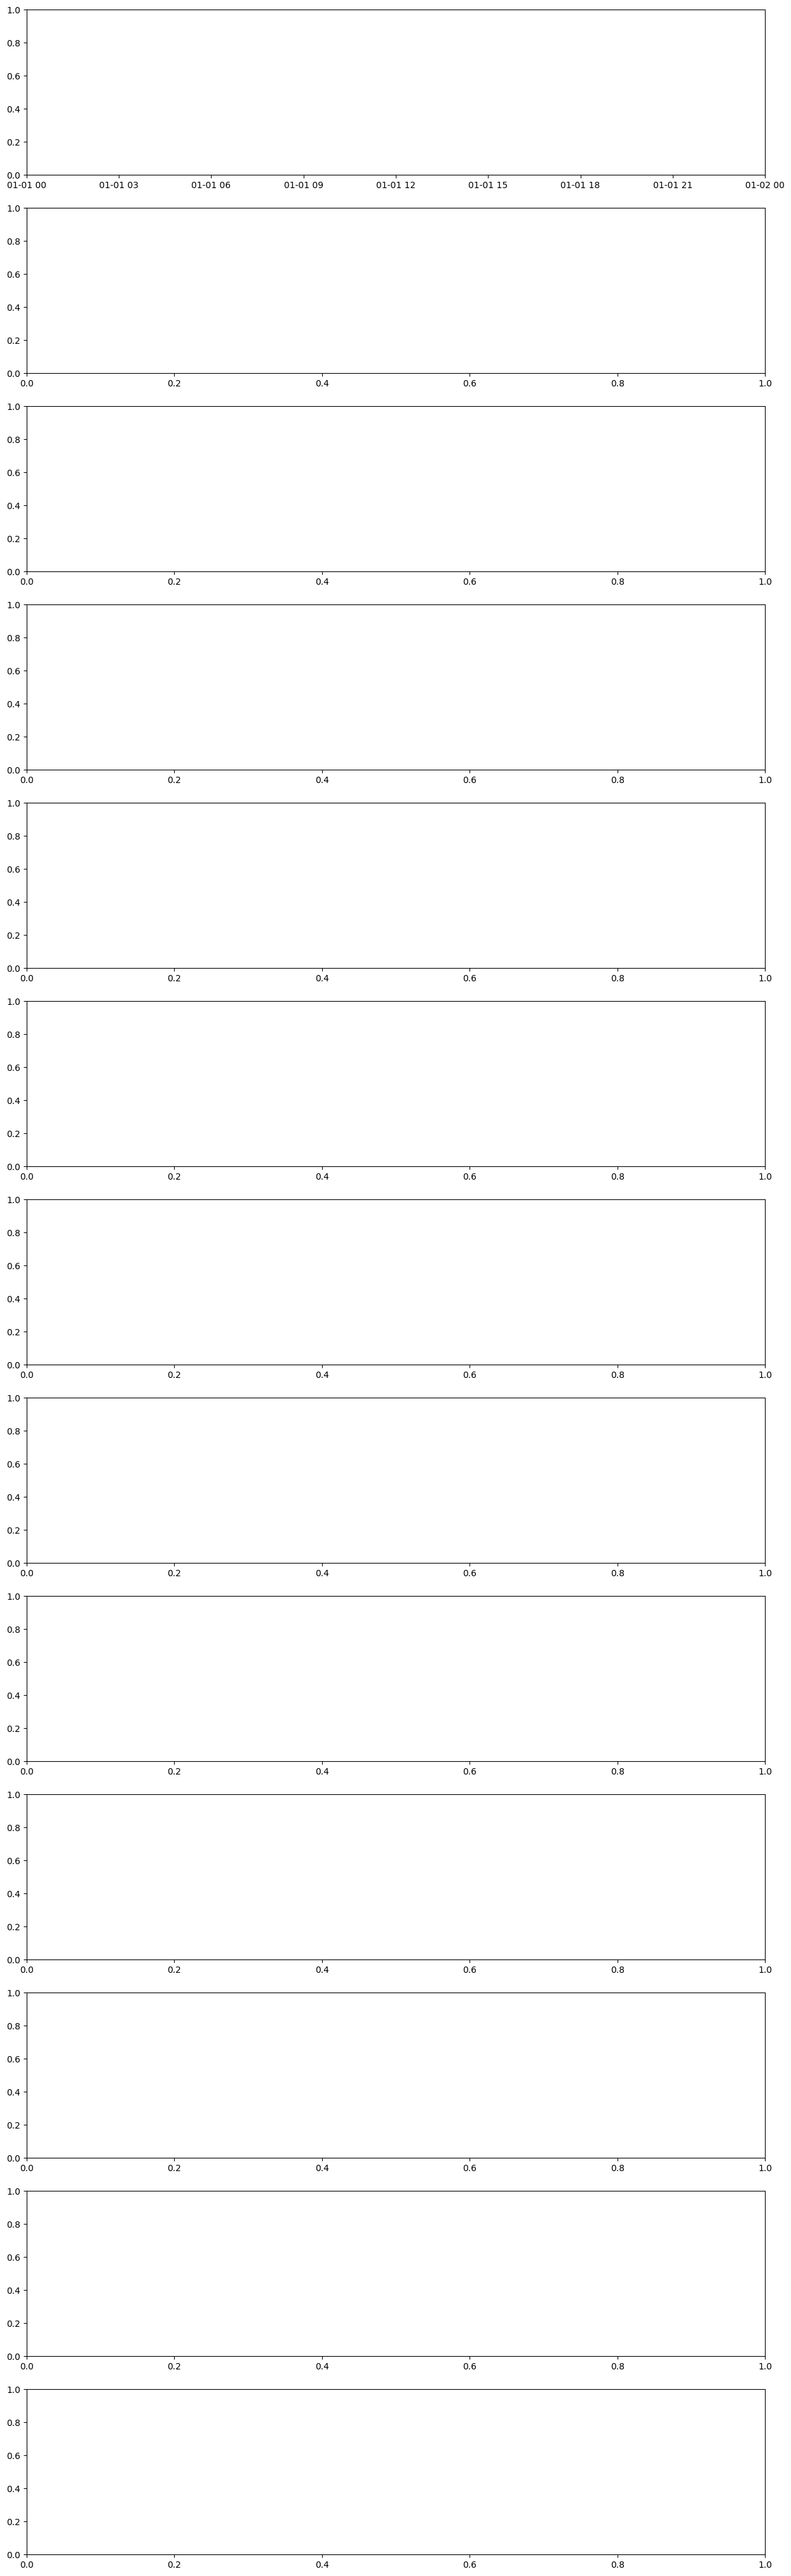

In [28]:
class SimpleFeedForward(nn.Module):
    """Example feedforward model"""
    def __init__(self, input_dim, hidden_dim=200, dropout=0):
        super(SimpleFeedForward, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        return self.network(x)
    
class SimpleLSTM(nn.Module):
    """Example LSTM model"""
    def __init__(self, input_dim, hidden_dim=200, num_layers=2, dropout=0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Use last time step output

class SimpleTransformer(nn.Module):
    def __init__(self,
                 input_dim: int,
                 model_dim: int = 128,   # divisible by nhead
                 nhead: int = 8,
                 num_layers: int = 2,
                 dropout: float = 0.1,
                 max_seq_length: int = 500):  # for positional encoding
        super().__init__()

        # project raw features to model_dim
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Add positional encoding 
        self.pos_encoding = PositionalEncoding(model_dim, dropout, max_seq_length)

        # vanilla encoder stack
        encoder_layer = nn.TransformerEncoderLayer(
                d_model=model_dim,
                nhead=nhead,
                dim_feedforward=model_dim * 4,  # standard practice
                dropout=dropout,
                activation='gelu',  # often works better than relu for transformers
                batch_first=True        # so x is (B, T, F)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # regression head with additional processing
        self.norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(model_dim, 1)

    def forward(self, x):               # x: (B, T, input_dim)
        x = self.input_proj(x)          # (B, T, model_dim)
        x = self.pos_encoding(x)        # Add positional information
        x = self.encoder(x)             # (B, T, model_dim)
        x = self.norm(x[:, -1])         # Layer norm on last time step
        x = self.dropout(x)             # Additional dropout
        return self.fc(x)               # (B, 1)


class PositionalEncoding(nn.Module):
    """Add positional encoding to input embeddings."""
    
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.transpose(0, 1)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)
    

results_ff = sp500_training_pipeline(
        X=features,
        y=target,
        dates=dates,
        model_class=SimpleTransformer,
        model_kwargs={'model_dim': 128, 'nhead': 8,
                      'num_layers': 2, 'dropout': 0.1},
        model_type='transformer',
        window_strategy='rolling',
        train_window_years=3,
        test_window_years=1,
        use_autoencoder=True,
        encoding_dim=10,
        walk_forward_cv=False,
        cv_months=12,
        epochs=80,
        alpha=0,
        l1_ratio=0,
        plot_results=True
    )
    